In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

Using TensorFlow backend.


In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, mean_proc='VGG16_ImageNet', test_size=0.1)

# ResNet50 Layer Transfer

## Using Flatten

In [3]:
model_name = 'ResNet50-Layer-Transfer'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.75)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    verbose=2)

Epoch 1/100
 - 25s - loss: 4.2076 - acc: 0.1973 - val_loss: 3.1427 - val_acc: 0.0702

Epoch 00001: val_loss improved from inf to 3.14266, saving model to ./saved_models/ResNet50-Layer-Transfer.h5
Epoch 2/100
 - 22s - loss: 2.4172 - acc: 0.3923 - val_loss: 3.1846 - val_acc: 0.0602

Epoch 00002: val_loss did not improve from 3.14266
Epoch 3/100
 - 23s - loss: 1.8837 - acc: 0.4918 - val_loss: 3.2667 - val_acc: 0.0635

Epoch 00003: val_loss did not improve from 3.14266
Epoch 4/100
 - 23s - loss: 1.5495 - acc: 0.5629 - val_loss: 3.4545 - val_acc: 0.0635

Epoch 00004: val_loss did not improve from 3.14266
Epoch 5/100
 - 22s - loss: 1.3394 - acc: 0.6175 - val_loss: 3.4905 - val_acc: 0.0702

Epoch 00005: val_loss did not improve from 3.14266
Epoch 6/100
 - 22s - loss: 1.2153 - acc: 0.6393 - val_loss: 3.5310 - val_acc: 0.0702

Epoch 00006: val_loss did not improve from 3.14266
Epoch 7/100
 - 22s - loss: 1.0888 - acc: 0.6671 - val_loss: 3.5720 - val_acc: 0.0736

Epoch 00007: val_loss did not imp

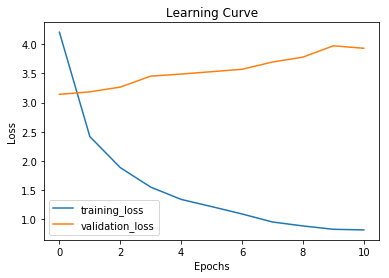

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

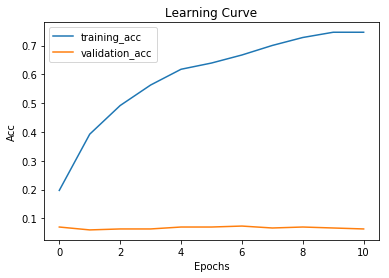

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [7]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 2s 6ms/step
Validation loss: 3.1426569187521536
Validation accuracy: 0.0702341138120479


## Using GlobalAveragePooling2D

In [8]:
model_name = 'ResNet50-Layer-Transfer-GlobalAveragePooling2D'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.75)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    verbose=2)

Epoch 1/100
 - 24s - loss: 3.4474 - acc: 0.0658 - val_loss: 2.7935 - val_acc: 0.0769

Epoch 00001: val_loss improved from inf to 2.79350, saving model to ./saved_models/ResNet50-Layer-Transfer-GlobalAveragePooling2D.h5
Epoch 2/100
 - 22s - loss: 3.1966 - acc: 0.0961 - val_loss: 2.7800 - val_acc: 0.0769

Epoch 00002: val_loss improved from 2.79350 to 2.78000, saving model to ./saved_models/ResNet50-Layer-Transfer-GlobalAveragePooling2D.h5
Epoch 3/100
 - 22s - loss: 2.9282 - acc: 0.1329 - val_loss: 2.7761 - val_acc: 0.0769

Epoch 00003: val_loss improved from 2.78000 to 2.77607, saving model to ./saved_models/ResNet50-Layer-Transfer-GlobalAveragePooling2D.h5
Epoch 4/100
 - 23s - loss: 2.8226 - acc: 0.1511 - val_loss: 2.7784 - val_acc: 0.0769

Epoch 00004: val_loss did not improve from 2.77607
Epoch 5/100
 - 22s - loss: 2.6394 - acc: 0.1728 - val_loss: 2.7804 - val_acc: 0.1003

Epoch 00005: val_loss did not improve from 2.77607
Epoch 6/100
 - 23s - loss: 2.5511 - acc: 0.2029 - val_loss: 2

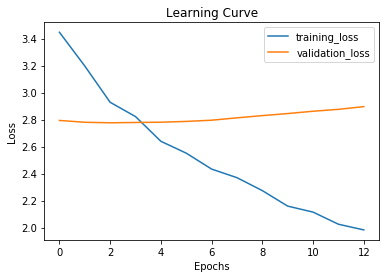

In [10]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

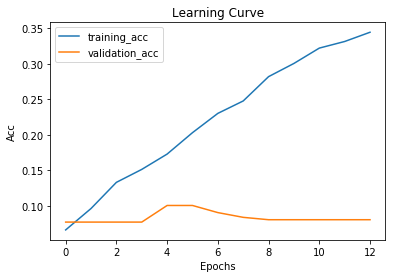

In [11]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [12]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 2s 7ms/step
Validation loss: 2.776069825309575
Validation accuracy: 0.07692307692307693


# ResNet50 Fine Tuning

In [13]:
model_name = 'ResNet50-Fine-Tuning'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.75)(x)
# x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    verbose=2)

Epoch 1/100
 - 37s - loss: 6.1963 - acc: 0.1367 - val_loss: 2.0580 - val_acc: 0.3712

Epoch 00001: val_loss improved from inf to 2.05799, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
Epoch 2/100
 - 26s - loss: 4.3376 - acc: 0.2451 - val_loss: 1.1769 - val_acc: 0.6288

Epoch 00002: val_loss improved from 2.05799 to 1.17692, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
Epoch 3/100
 - 26s - loss: 3.2329 - acc: 0.3761 - val_loss: 0.8910 - val_acc: 0.7458

Epoch 00003: val_loss improved from 1.17692 to 0.89100, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
Epoch 4/100
 - 26s - loss: 2.7056 - acc: 0.4559 - val_loss: 0.7306 - val_acc: 0.7926

Epoch 00004: val_loss improved from 0.89100 to 0.73061, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
Epoch 5/100
 - 26s - loss: 2.2134 - acc: 0.5360 - val_loss: 0.6286 - val_acc: 0.8294

Epoch 00005: val_loss improved from 0.73061 to 0.62859, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
Epoch 6/100
 - 26s 

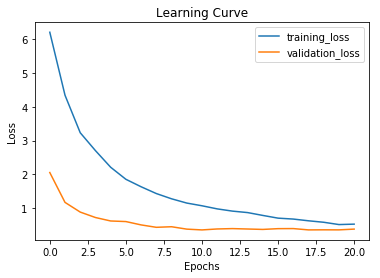

In [15]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

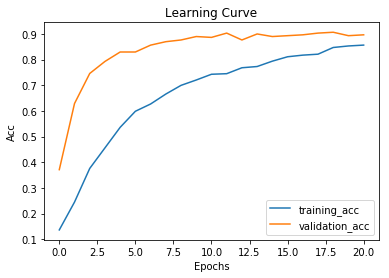

In [16]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 3s 11ms/step
Validation loss: 0.3648931732943225
Validation accuracy: 0.8862876264147934
